# POPPY Simulation: UA Wavefront Testbed (Phase 1, no optics surfaces)
## Notes:
- <b>Testbed Design Version</b>: 2016/09/26, Kelsey Miller. See data/Testbed_Layout_Schematic_Oct_2016.pdf for additional details.
- This notebook only models phase 1, which replaces OAP4 with the characteristics of OAP1/2/3. There are some angle changes and additional optics in place not shown in the design.
- This version has no surface maps implemented. It is meant as a reference to show that the testbed layout does work. There will be a separate file version with the surface maps implemented.
- This notebook calculates the F/# focal plane generation to make any distance corrections.
- The testbed uses a diverging beam source, so this notebook "fakes" it in with a negative lens.

In [2]:
%matplotlib inline
import numpy as np

# plotting tools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib

# units
from astropy import units as u
from astropy.io import fits

# POPPY
import poppy
from poppy.poppy_core import PlaneType
poppy.__version__

# Import external functions file; written for magaox_poppy
import magaoxFunctions as mf

## Initiate the optical elements and variables
### Optical elements not implemented:
- vAPP mask (placement missing)
- MagAOX Pupil (placement missing)
- BMC 1K DM powered flat surface
- IrisAO DM powered flat surface

### Assumptions made:
- Deformable mirrors (Iris AO, BMC 1K) are implemented as regular mirrors. 

### Other missing data:
- Collimating lens placement (preferrably from second F/39 focal plane)
- vAPP mask placement (needs distance from collimating lens)
- Are there any additional optics between vAPP mask and camera?

In [3]:
# define system parameters
EP_diam = 0.0067 * u.m # 6.8mm beam diameter used as entrance pupil, changed due to vAPP requirements
oversamp = 0.125
samp = 256

halpha = 656e-9 * u.m

# define physical sizes
oap_radius = 0.254 * u.m # 2 inch diameter
irisAO_radius = 0.254 * u.m # don't know size, going to assume 2 inch diameter
BMC1K_radius = 0.254 * u.m # also don't know size, but it's large enough
colLens_radius = 0.254 * u.m # I think it's a 2 inch diameter
imgLens_radius = 0.254 * u.m # Assuming 2 inch diameter

# define focal lengths
fl_OAP = 0.273 * u.m # all OAPs are the same focal length
fl_colLens = 0.350 * u.m # kelsey defined
fl_imgLens = 0.100 * u.m # Placeholder until Kelsey chooses the lens

# define distances
d_src_oap1 = 0.273 * u.m
d_oap1_irisAO = 0.273 *u.m
d_irisAO_oap2 = 0.273 * u.m
d_oap2_f39 = 0.273 * u.m
d_f39_oap3 = 0.273 * u.m
d_oap3_BMC1K = 0.273 * u.m
d_BMC1K_oap4 = 0.273 * u.m
d_oap4_f39 = 0.273 * u.m
d_f39_colLens = 0.350 * u.m 
d_colLens_vAPP = 0.350 * u.m # Placeholder until Kelsey confirms
d_vAPP_imgLens = 0.100 * u.m
d_imgLens_camera = 0.100 * u.m

# focal plane correction distances, calculated in the past and can be found in a past version
f39f1_delta = -7.0437744e-6 * u.m
f39f2_delta = -7.0437744e-6 * u.m

# initialize optical elements
diverge_source = poppy.QuadraticLens(-(d_src_oap1),name='Diverging Source') 
# finite distance source is a negative lens to simulate dispersive source
colLens = poppy.QuadraticLens(fl_colLens, name='Collimating Lens')
imgLens = poppy.QuadraticLens(fl_imgLens, name='Imaging Lens')

# Declare OAP mirrors
OAP1 = poppy.QuadraticLens(fl_OAP, name='OAP-1')
OAP2 = poppy.QuadraticLens(fl_OAP, name='OAP-2')
OAP3 = poppy.QuadraticLens(fl_OAP, name='OAP-3')
OAP4 = poppy.QuadraticLens(fl_OAP, name='OAP-4')

Make vAPP Mask files

In [4]:
vapp_phase_data = fits.open('data/coronagraph/MagAOx_256x256_phase_nograting.fits')[0].data
vapp_aperture_data = fits.open('data/coronagraph/MagAOx_256x256_amp.fits')[0].data

vAPP_folder = 'data/coronagraph/'
vAPP_diam = 0.0086 # units: meters. Kelsey selected 8.6mm beam diameter at vAPP.
vAPP_pixelscl = vAPP_diam/samp # vAPP is sized to whatever the sampling is set.

vapp_opd_surf_data = 1*(halpha.value/(2*np.pi))*vapp_phase_data*vapp_aperture_data
vAPP_opd_filename = 'vAPP_opd_mask_1PSF_256'
mf.writeOPDfile(vapp_opd_surf_data, vAPP_pixelscl, vAPP_folder + vAPP_opd_filename + '.fits')

vAPP_trans_filename = 'vAPP_trans_mask_1PSF_256'
mf.writeTRANSfile(vapp_aperture_data, vAPP_pixelscl, vAPP_folder + vAPP_trans_filename + '.fits')

Pass in all the required surfaces from FITS files

In [5]:
#pupil = mf.surfFITS(file_loc='data/MagAOX_f11_pupil_256_unmasked.fits', optic_type='trans', opdunit='none', 
#                 name='MagAO-X Pupil (unmasked)')
vapp_opd = mf.surfFITS(file_loc=vAPP_folder+vAPP_opd_filename+'.fits', optic_type='opd', opdunit='meters', 
                      name='vAPP mask (OPD)')
vapp_trans = mf.surfFITS(file_loc=vAPP_folder+vAPP_trans_filename+'.fits', optic_type='trans', opdunit='none', 
                      name='vAPP mask (transmission)')

# Build Testbed optical system to first F/39 focal plane

In [6]:
# Initialize FresnelOpticalSystem
uawfstb = poppy.FresnelOpticalSystem(pupil_diameter = EP_diam, npix=samp, beam_ratio=oversamp)

# First surface is the entrance aperture.
uawfstb.add_optic(poppy.CircularAperture(radius=EP_diam/2)) # not sure why multiplying by 0.4?

# To simulate a diverging pt source, use a negative-power lens with focal length -d, 
# where d is distance prior to entrance aperture
uawfstb.add_optic(diverge_source)

# Add in OAP1
uawfstb.add_optic(OAP1) # I don't understand why, but there doesn't need to be a distance here. 
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP1 aperture"))
# Light should be collimated at this point

# Add in IrisAO DM, just a "perfect" mirror
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="IrisAO DM"), 
                                            distance=d_oap1_irisAO)
uawfstb.add_optic(poppy.CircularAperture(radius=irisAO_radius,name="IrisAO aperture"))

# add in OAP2
uawfstb.add_optic(OAP2, distance=d_irisAO_oap2)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP2 aperture"))
# Light should be converging at this point

# Add in F/39 focal plane
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/39 focal plane"), 
                                            distance=d_oap2_f39+f39f1_delta)

This block is for F/39 first focal plane, skip this line unless you want to calculate f39f1_delta. This is kept here in case there's a change in optical distance, etc.

Keep note that the f39f1_delta is already added to the F/39 focal plane distance.

In [20]:
# Focal plane correction for F/39
unfixed_f39fp_psf, unfixed_f39fp_wfs = uawfstb.calcPSF(wavelength=halpha, display_intermediates=False, return_intermediates=True)
f39_last_wave = unfixed_f39fp_wfs[-1]
f39f1_delta = f39_last_wave.z_w0 - f39_last_wave.z #f39_delta is the change in distance to compensate the gaussian beam waist.

f39f1_delta

# Incorporate the correction distance to see the F/39 PSF.
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/39 focal plane (corrected)"), distance=f39f1_delta)

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


Continue building to the next F/39 focal plane.

In [7]:
# add in OAP3
uawfstb.add_optic(OAP3, distance=d_f39_oap3)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP3 aperture"))
# Light should be collimated at this point

# Add in BMC 1K DM, just a "perfect" mirror
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="BMC 1K DM"), 
                                            distance=d_oap3_BMC1K)
uawfstb.add_optic(poppy.CircularAperture(radius=BMC1K_radius,name="BMC 1K DM aperture"))

# add in OAP4
uawfstb.add_optic(OAP2, distance=d_BMC1K_oap4)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP4 aperture"))
# Light should be converging at this point

# Add in second F/39 focal plane
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Second F/39 focal plane"), 
                                            distance=d_oap4_f39+f39f2_delta)


Calculating correction distance for second F/39. Please skip, f39f2_delta is already added in the build. This is kept here for changed distance, etc.

In [23]:
# Focal plane correction for F/39
unfixed_f39f2_psf, unfixed_f39f2_wfs = uawfstb.calcPSF(wavelength=halpha, display_intermediates=False, return_intermediates=True)
f39f2_last_wave = unfixed_f39f2_wfs[-1]
f39f2_delta = f39f2_last_wave.z_w0 - f39f2_last_wave.z #f39_delta is the change in distance to compensate the gaussian beam waist.

f39f2_delta

# Incorporate the correction distance to see the F/39 PSF.
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Second F/39 focal plane (corrected)"), distance=f39f2_delta)

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


Add in collimating lens to make a pupil plane for vAPP, vAPP mask, and add in imaging lens for the PSF.

In [8]:
# Add in collimating lens for vAPP mask
uawfstb.add_optic(colLens, distance=d_f39_colLens)
uawfstb.add_optic(poppy.CircularAperture(radius=colLens_radius,name="collimating lens aperture"))
# Light should be collimating at this point

# Add in vAPP mask here, but I don't know the distance, so ignoring for now
uawfstb.add_optic(vapp_trans, distance=d_colLens_vAPP)
uawfstb.add_optic(vapp_opd)
uawfstb.add_optic(poppy.CircularAperture(radius=vAPP_diam/2*u.m,name="vAPP aperture"))

# Add in imaging lens
uawfstb.add_optic(imgLens, distance=d_vAPP_imgLens)
uawfstb.add_optic(poppy.CircularAperture(radius=imgLens_radius,name='Imaging lens aperture'))

# Add in the location of the camera for science PSF
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Science Camera"), 
                                            distance=d_imgLens_camera) # 50mm distance from colLens

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
Optic(256, 256) is smaller than input wavefront[2048, 2048], will attempt to zero-pad the rescaled array
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
Optic(256, 256) is smaller

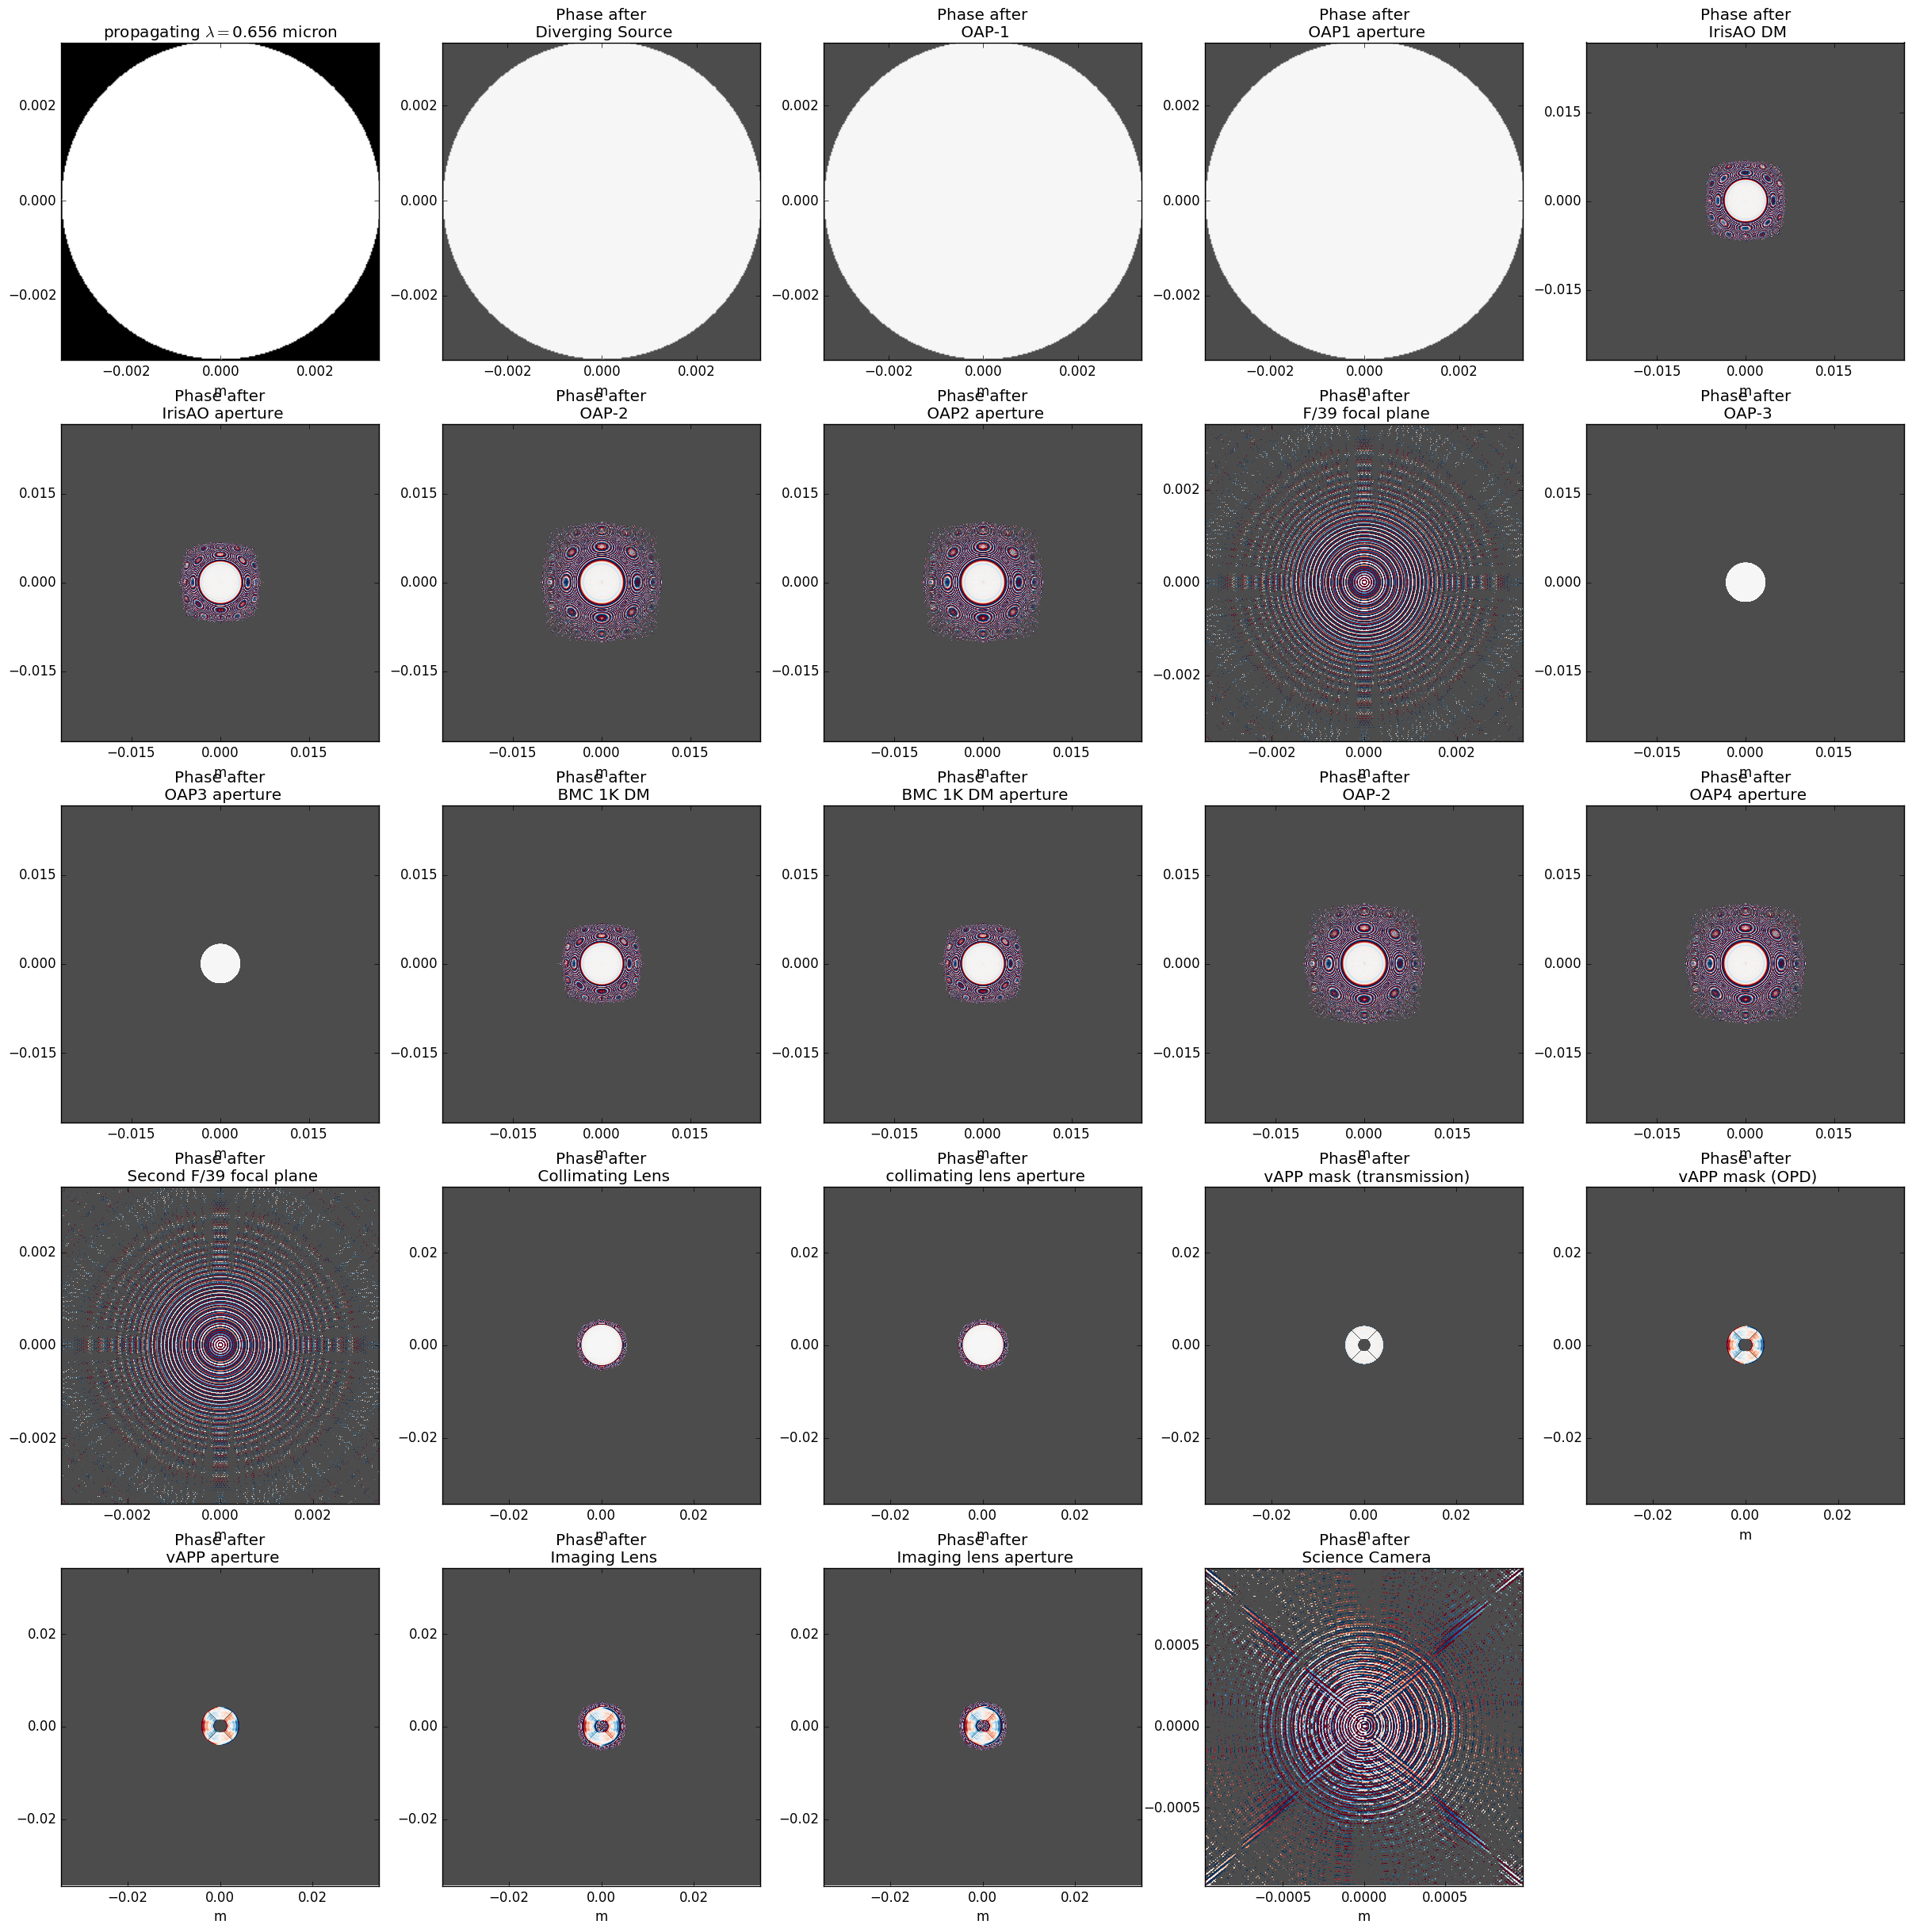

In [9]:
matplotlib.rcParams["font.size"]=12
plt.figure(figsize=[30,30])
sciplane_psf, sciplane_wfs = uawfstb.calcPSF(wavelength=halpha, 
                                        display_intermediates=True, 
                                        return_intermediates=True, save_intermediates=True)

The phase on the camera looks promising!! Let's look at the PSF on the camera.

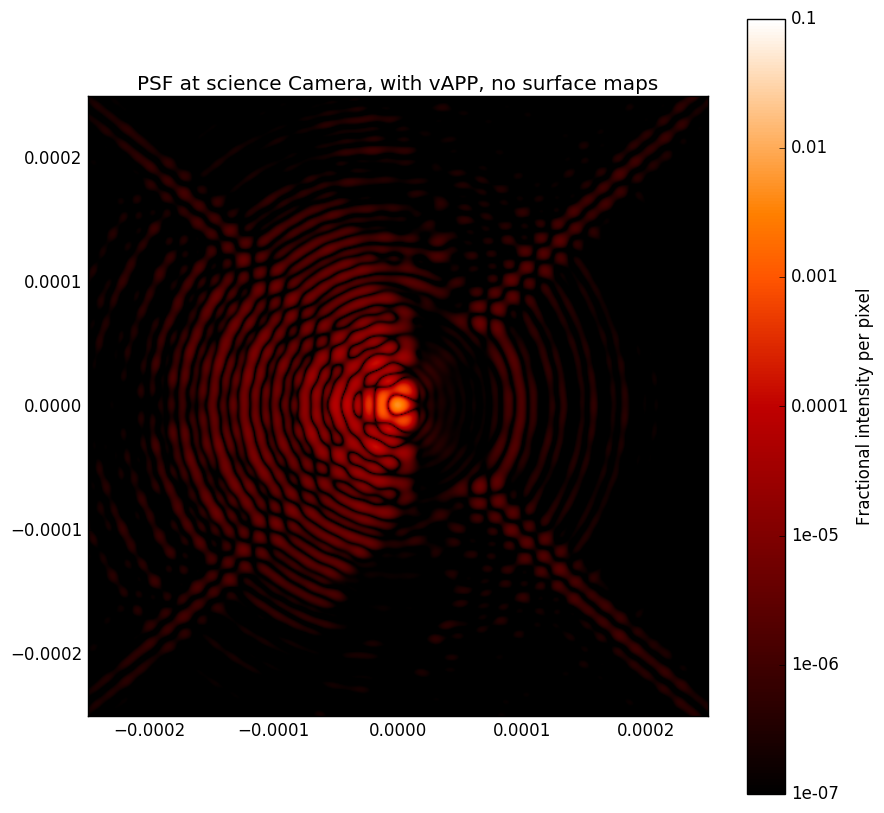

In [10]:
plt.figure(figsize=[10,10])
poppy.display_PSF(sciplane_psf, imagecrop=0.0005)
plt.title("PSF at science Camera, with vAPP, no surface maps")

(Nigel Thornberry voice) SMASHING!!